# **Rossmann Sales Prediction**

A Rossmann é uma das maiores redes de drogarias da Europa. Nesse contexto de negócio, O CFO da empresa solicitou uma previsão das vendas das lojas para as próximas 6 semanas, o problema que o CFO está enfrentando é ter uma noção clara do orçamento disponível para planejar as reformas das lojas da empresa. O CFO também é uma pessoa muito ocupada e precisa que a solução esteja disponível no seu celular para que ele possa acessar de qualquer lugar com acesso à internet.

O projeto abaixo foi feito utilizando dados de vendas da Rossmann disponibilizados no site www.kaggle.com.

## Dicionário dos Dados

| Coluna                | Descrição                                                                                                                                  |
|-----------------------|--------------------------------------------------------------------------------------------------------------------------------------------|
| Id                    | um Id que representa um (Store, Date) duplo dentro do conjunto de teste                                                                    |
| Store                  | um ID exclusivo para cada loja                                                                                                             |
| Sales                | o volume de negócios de um determinado dia (é isso que estou prevendo)                                                                 |
| Customers              | o número de clientes em um determinado dia                                                                                                |
| Open                | um indicador para saber se a loja estava aberta: 0 = fechada, 1 = aberta                                                                   |
| StateHoliday          | indica um feriado estadual. Normalmente, todas as lojas, com poucas exceções, fecham em feriados estaduais. a = feriado, b = Páscoa, c = Natal, 0 = Nenhum |
| SchoolHoliday         | indica se a (Loja, Data) foi afetada pelo fechamento de escolas públicas                                                                   |
| StoreType             | diferencia entre 4 modelos de loja diferentes: a, b, c, d                                                                                  |
| Assortment            | descreve um nível de sortimento: a = básico, b = extra, c = estendido                                                                      |
| CompetitionDistance   | distância em metros até a loja concorrente mais próxima                                                                                    |
| CompetitionOpenSince[Month/Year]  |  fornece o ano e o mês aproximados da abertura do concorrente mais próximo                                                     |
| Promo              | indica se uma loja está realizando uma promoção naquele dia                                                                                |
| Promo2                | Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = loja não está participando, 1 = loja está participando                 |
| Promo2Since[Year/Week]           | descreve o ano e a semana do calendário em que a loja começou a participar do Promo2                                          |
| PromoInterval         | descreve os intervalos consecutivos em que o Promo2 é iniciado, nomeando os meses em que a promoção é iniciada novamente. Por exemplo, "fev, mai, ago, nov" significa que cada rodada começa em fevereiro, maio, agosto, novembro de qualquer ano para aquela loja |


# 0.0 IMPORTS

In [2]:
import math
import inflection
import datetime
import numpy                as np
import pandas               as pd
import seaborn              as sns
import matplotlib.pyplot    as plt
import xgboost              as xgb
import pickle
from IPython.display        import Image
from matplotlib.gridspec    import GridSpec
from scipy.stats            import chi2_contingency
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder
from boruta                 import BorutaPy
from sklearn                import ensemble        as en    
from sklearn                import metrics         as mt
from sklearn                import linear_model    as lm
plt.style.use('ggplot')

## 0.1 Helper Functions

In [3]:
pd.set_option('display.max_columns', None)

def cramer_v( x, y ):
    """ Esta função tem a responsabilidade de calcular a
        associação entre duas variáveis categóricas, medida pela
        estatística de Cramer's V, que varia de 0 a 1, onde 
        0 indica nenhuma associação e 1 indica uma associação perfeita.
    """
    cm = pd.crosstab( x, y ).values # Faz todas as possíveis combinações entre as variáveis categóricas e conta o número de linhas de cada combinação
    n = cm.sum()
    r, k = cm.shape

    chi2 = chi2_contingency( cm )[0]
    chi2_no_bias = max( 0, chi2 - (k-1)*(r-1)/(n-1) ) # Corrigindo o viés do teste qui-quadrado

    k_no_bias = k - (k-1)**2/(n-1)
    r_no_bias = r - (r-1)**2/(n-1)

    return np.sqrt( (chi2_no_bias/n) / ( min( k_no_bias-1, r_no_bias-1 ) ) )

#--------------------------------------------------------------------------------------------------------------

def ml_error( model_name, y, yhat ):
    """ Essa função tem o objetivo de calcular métricas de erro comuns para as previsões de um modelo de machine learning.
        As métricas calculadas são: Erro Médio Absoluto (MAE), Erro Médio Absoluto Percentual (MAPE) e a Raiz do Erro Quadrático
        Médio (RMSE). A função retorna essas métricas em um DataFrame, junto com o nome do modelo.
    """
    mae = mt.mean_absolute_error( y, yhat )
    mape = mt.mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mt.mean_squared_error( y, yhat ) )

    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

#--------------------------------------------------------------------------------------------------------------

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    """ Essa função tem o objetivo de partir o dataset em 'kfold' pedaços, selecionar 1 fatia, treinar com o resto e
        testar na fatia que ele separou. Depois ele pega outro 'pedaço' do dataset e faz a mesma coisa até percorrer todo
        o dataset. Para cada 'kfold' pedaços a função mede a performance e ao final tira a média dessas 'kfold' performances
        +/- o desvio padrão e essa é a performance real do modelo.
    """
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + '+/-' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + '+/-' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + '+/-' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )
#--------------------------------------------------------------------------------------------------------------

def mean_percentage_error( y, yhat ):
    """ Essa função calcula o erro MPE para entender se o modelo está Subestimando ou Superestimando
    """
    return np.mean( ( y - yhat ) / y )


## 0.2 Loadind Data

In [4]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0. DESCRIÇÃO DOS DADOS

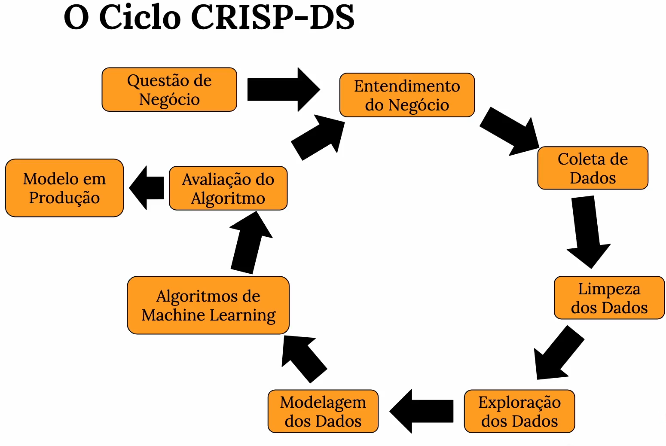

In [5]:
# Metodologia utilizada
Image( 'img/crisp_ds.png' )

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [8]:
print( 'Number of Rows:{}'.format( df1.shape[0] ) )
print( 'Number of Cols:{}'.format( df1.shape[1] ) )

Number of Rows:1017209
Number of Cols:18


## 1.3. Data Types

In [9]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [11]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
    
#competition_open_since_year  
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )
                             
#promo2_since_week 
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year   
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )            

#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

df1['promo_interval'] = df1['promo_interval'].fillna(0)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',')  else 0, axis=1  )
                 

## 1.6. Change Types

In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( np.int64 )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( np.int64 )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( np.int64 )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( np.int64 )

## 1.7. Descriptive Statistical


In [13]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [14]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T


# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max )  ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
metrics = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical Attributes

In [15]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

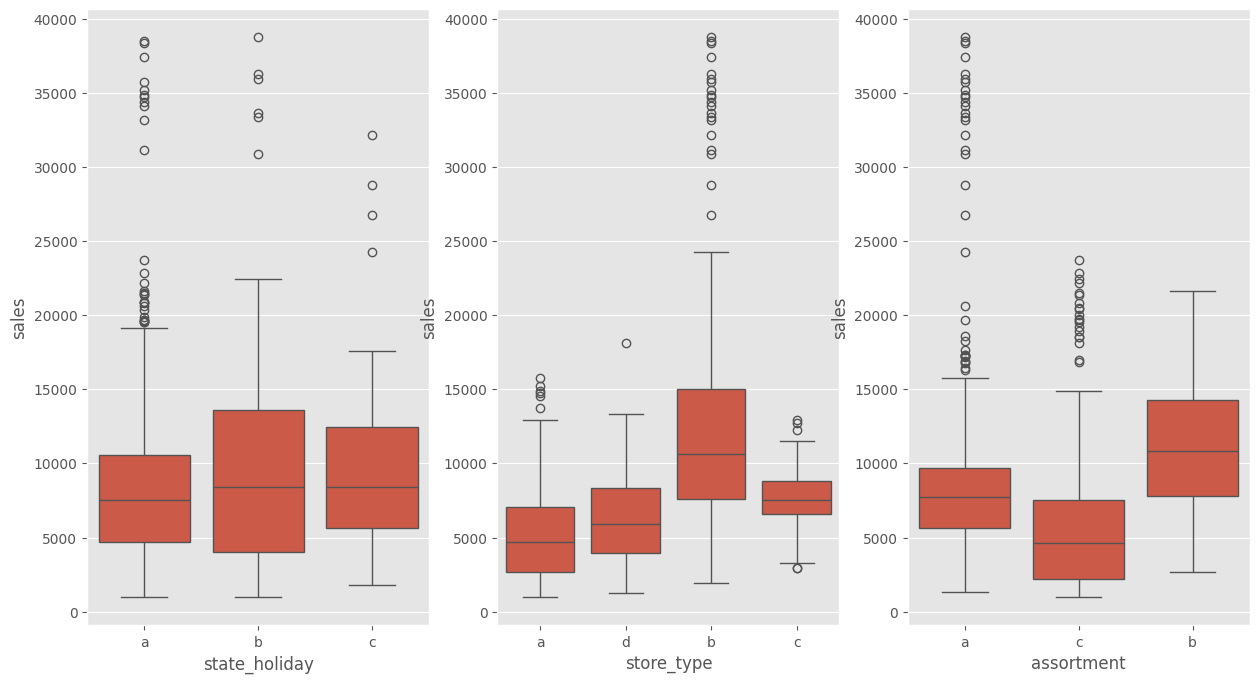

In [16]:
df_aux = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0 )]
plt.figure(figsize=(15,8))

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=df_aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=df_aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=df_aux )


# 2.0. FEATURE ENGINEERING


In [17]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

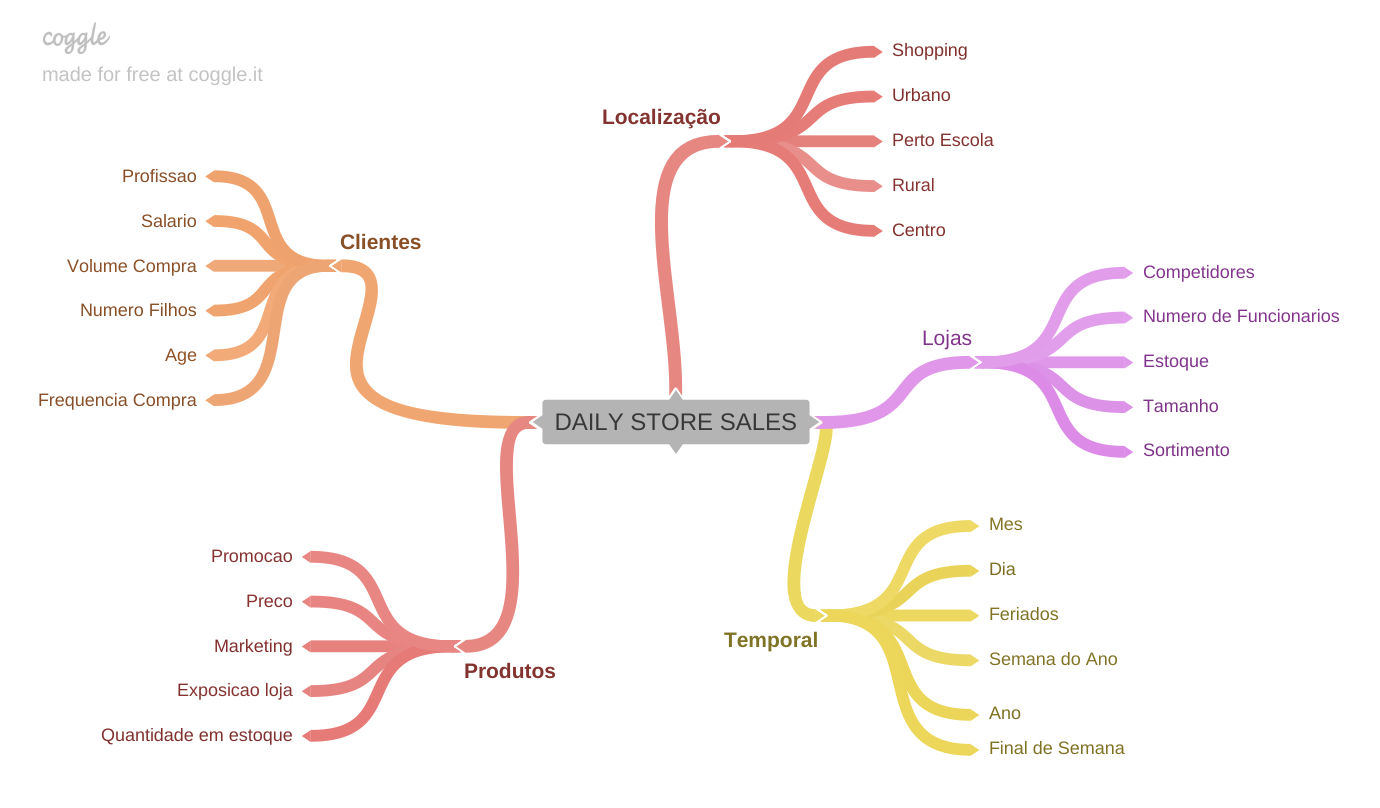

In [18]:
Image( 'img/MindMapHypothesis.png' )

## 2.2. Criação das Hipóteses

### 2.2.1. Hipoteses Loja


**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Hipoteses Produto


**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipoteses Temporais ( Sazonalidade )


**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.


## 2.4. Feature Engineering

In [19]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [ ]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. FILTRAGEM DE VARIÁVEIS

In [ ]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [ ]:
df3 = df3[(df3['open'] != 0 ) & (df3['sales'] > 0 ) ]

## 3.2. Seleção das Colunas


In [ ]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0. ANÁLISE EXPLORATÓRIA DOS DADOS ( EDA )

In [ ]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Response Variable

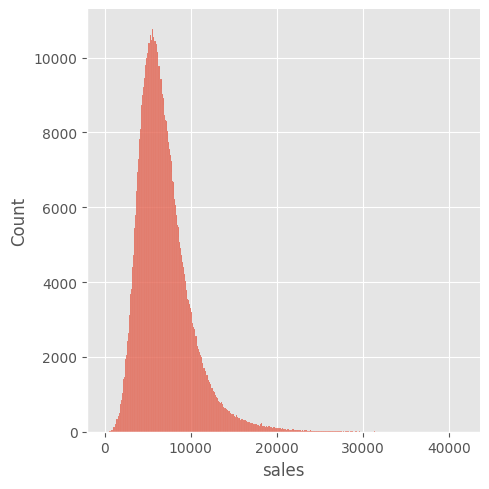

In [ ]:
sns.displot(df4['sales'], kde=False)



### 4.1.2. Numerical Variable

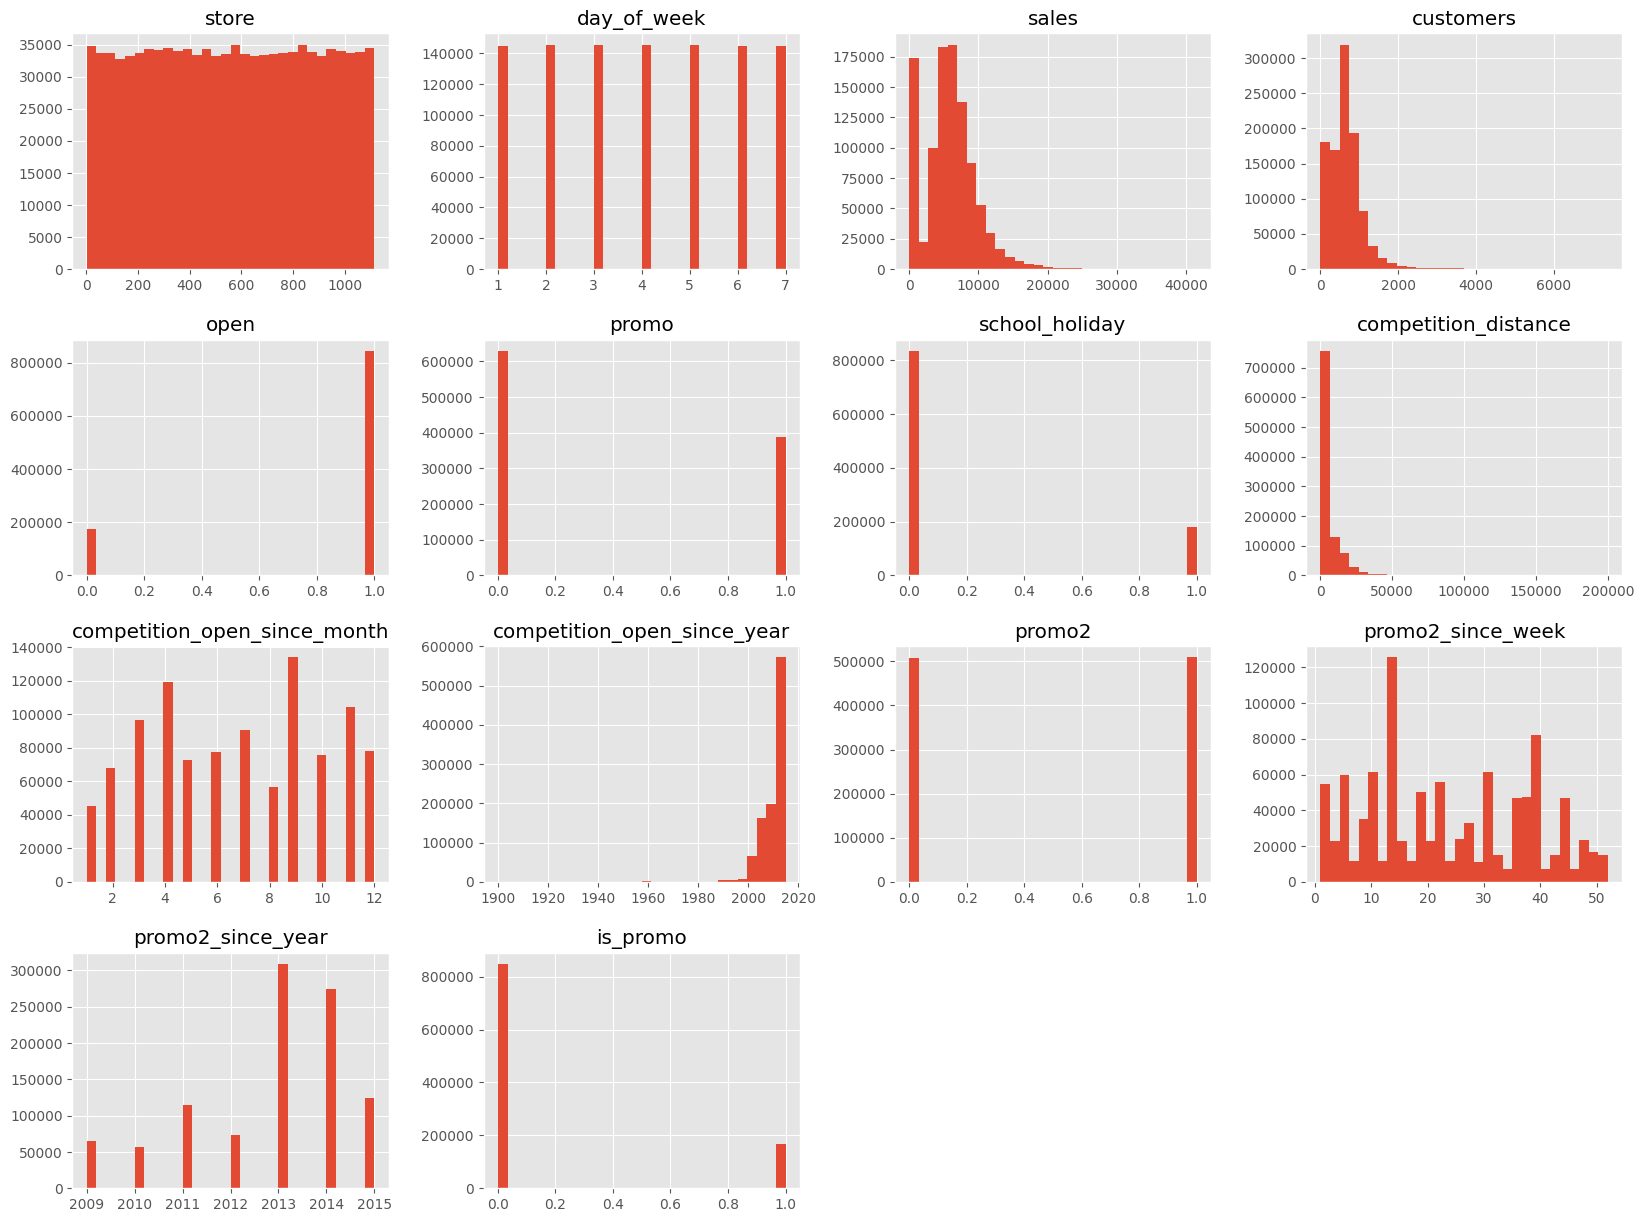

In [ ]:
num_attributes.hist( bins=30, figsize=(20,15));


### 4.1.3. Categorical Variable

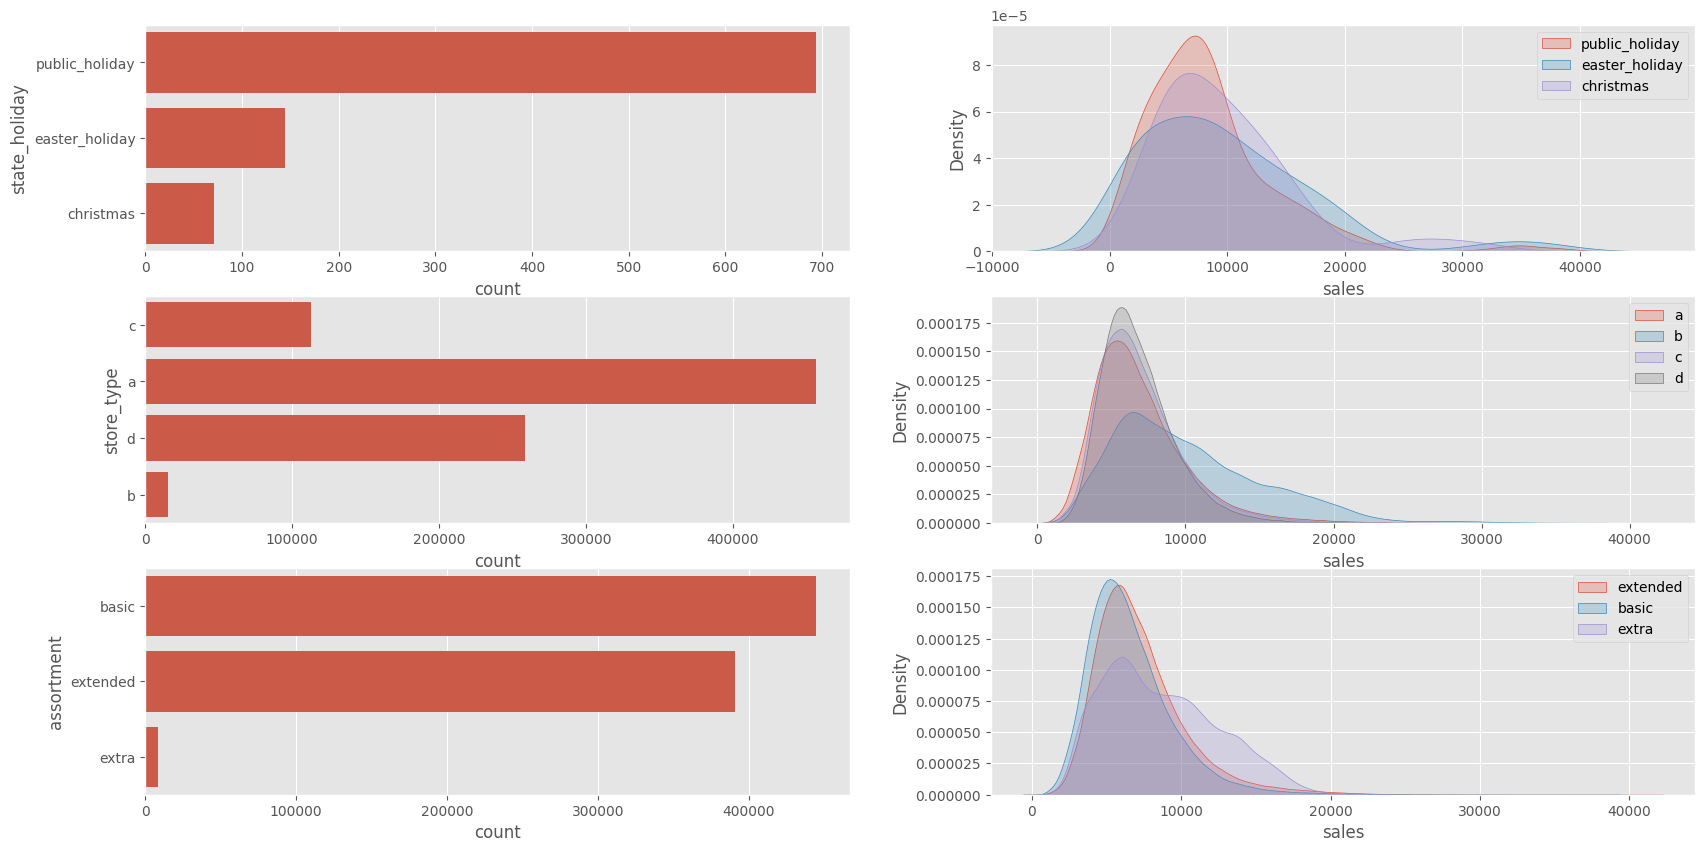

In [ ]:
plt.figure(figsize=(20,10))

# state holiday
plt.subplot( 3, 2, 1)
aux = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( aux['state_holiday'])

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True )
plt.legend()

# store type
plt.subplot( 3, 2, 3)
sns.countplot( df4['store_type'])

plt.subplot( 3, 2, 4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True )
plt.legend()

# assortment
plt.subplot( 3, 2, 5)
sns.countplot( df4['assortment'])

plt.subplot( 3, 2, 6)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True )
plt.legend()


## 4.2. Análise Bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.
**Hipótese Verdadeira.** As lojas com MAIOR sortimento, apresentam MAIOR média de Vendas.



Text(0.5, 1.0, 'Média de vendas por nível de sortimento ao longo das semanas do ano')

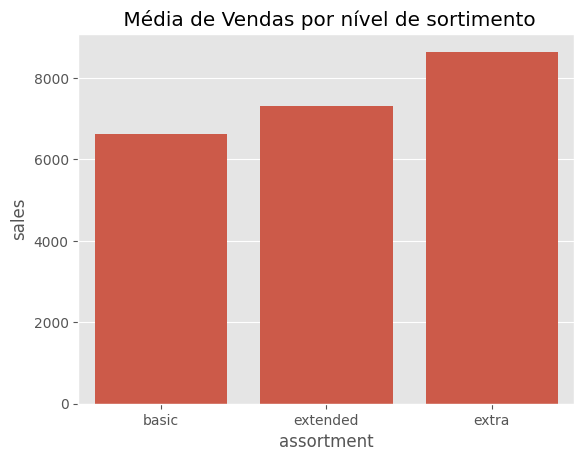

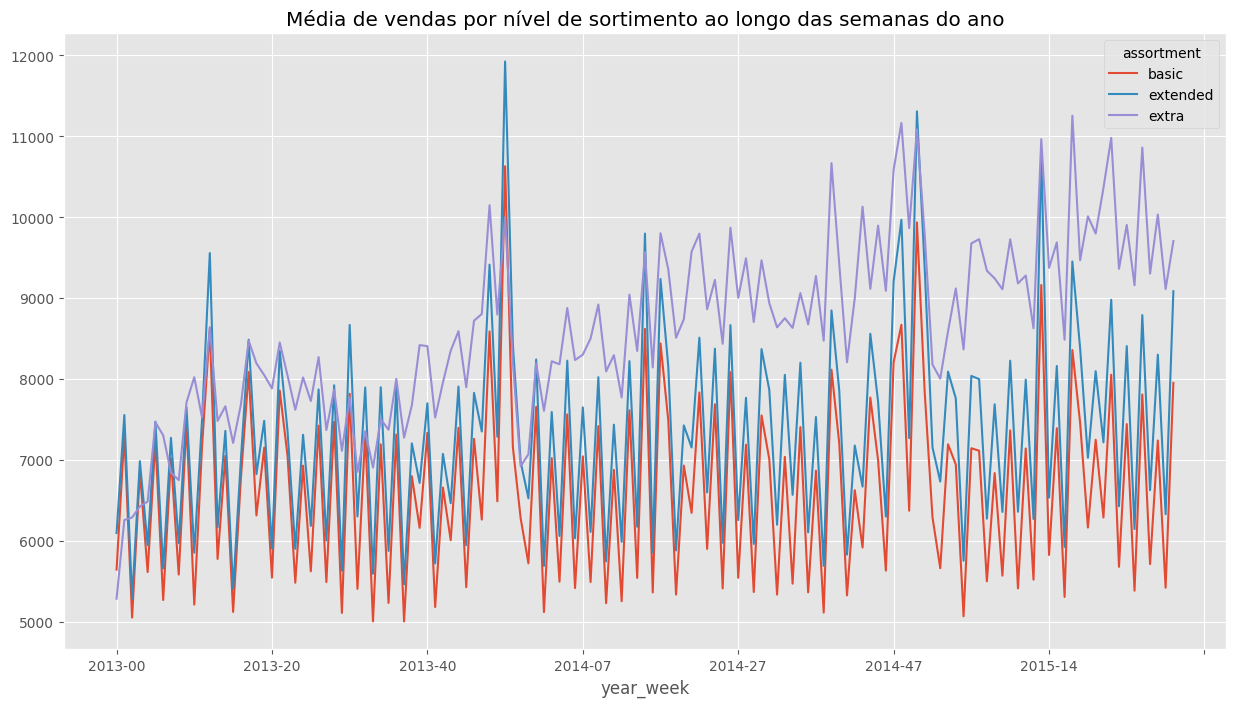

In [ ]:
df_aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).mean().reset_index()
sns.barplot( x='assortment', y='sales', data=df_aux1 );
plt.title(' Média de Vendas por nível de sortimento')

df_aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).mean().reset_index()
df_aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot(figsize=(15,8))
plt.title('Média de vendas por nível de sortimento ao longo das semanas do ano')

In [ ]:
df_aux2.head()

,year_week,assortment,sales
0,2013-00,basic,5642.277194
1,2013-00,extended,6094.001471
2,2013-00,extra,5282.431373
3,2013-01,basic,7307.459961
4,2013-01,extended,7553.623270


### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**Hipótese Falsa** Lojas com competidores MAIS próximos vendem MAIS em média. Os dados nos mostram que a competição não influencia negativamente nas vendas das lojas

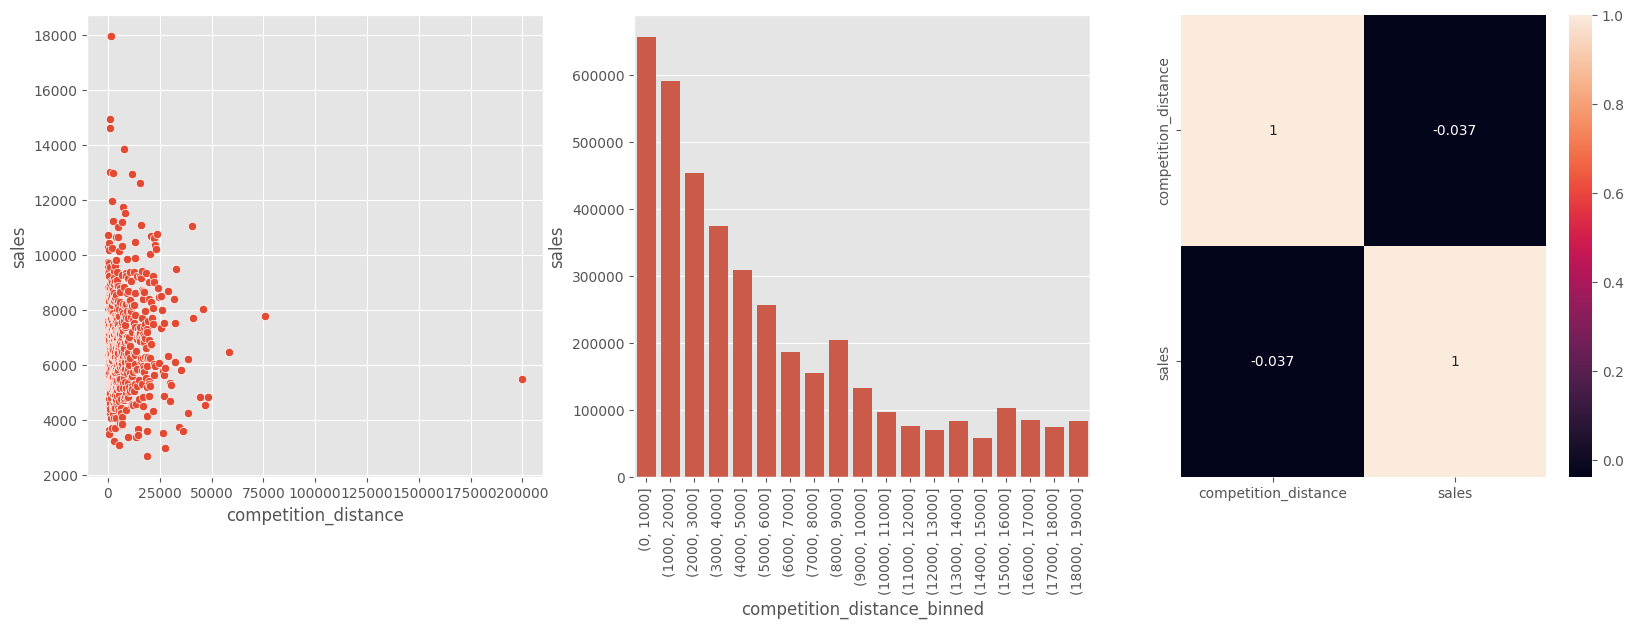

In [ ]:
df_aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance').mean().reset_index()

plt.figure( figsize=(20,6))
plt.subplot( 1, 3, 1 )
sns.scatterplot( x='competition_distance', y='sales', data=df_aux1 )

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000 ) )
df_aux1['competition_distance_binned'] = pd.cut(df_aux1['competition_distance'], bins = bins)
df_aux2 = df_aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned', observed=False).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=df_aux2);
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
sns.heatmap( df_aux1[['competition_distance', 'sales']].corr( method='pearson' ), annot=True );

### **H3.** Lojas com competidores a mais tempo deveriam vendem mais.
**Hipótese Falsa.** Lojas com competidores há MAIS TEMPO vendem MENOS.

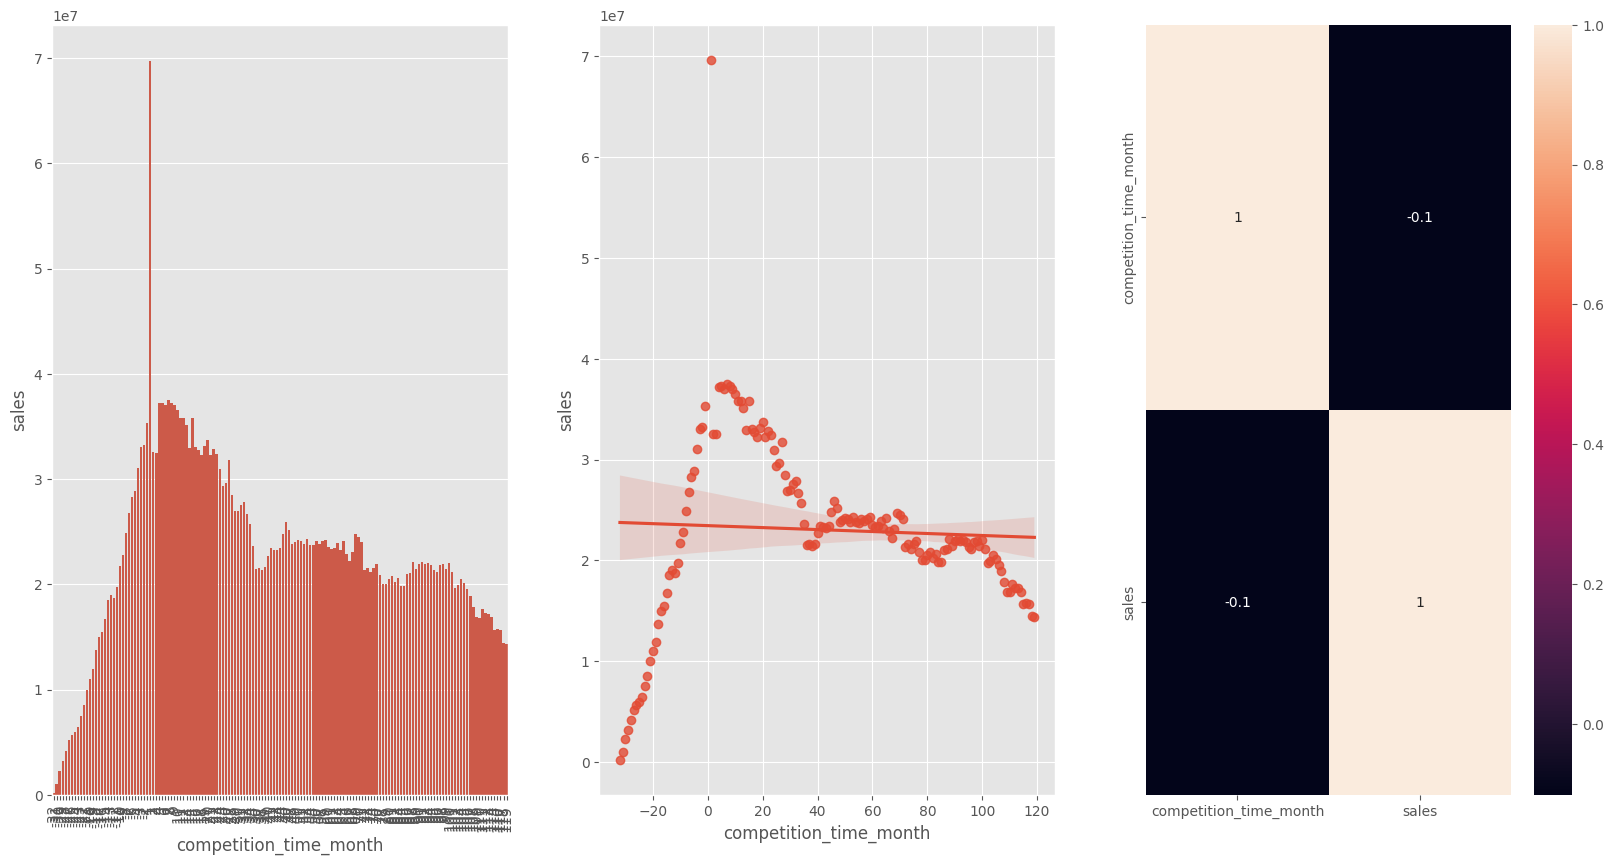

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot( 1, 3, 1 )
df_aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
df_aux2 = df_aux1[(df_aux1['competition_time_month'] < 120 ) & ( df_aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=df_aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=df_aux2 );

plt.subplot( 1, 3, 3 )
sns.heatmap( df_aux1.corr( method='pearson'), annot=True );


### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**Hipótese Falsa.** Lojas com promoção contínua têm uma queda nas vendas depois de um certo período.




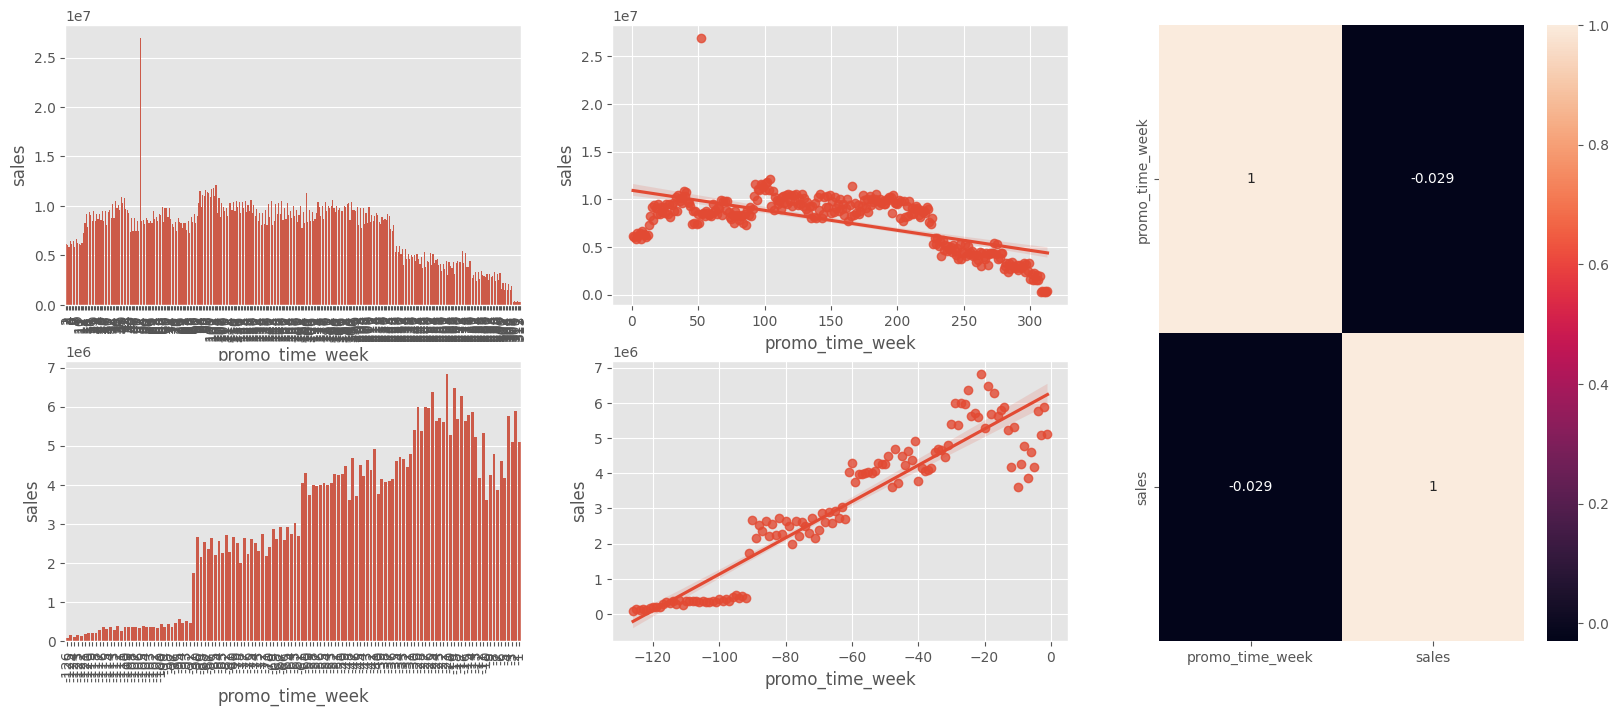

In [ ]:
df_aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()
plt.figure(figsize=(20,8))

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
df_aux2 = df_aux1[df_aux1['promo_time_week'] > 0] # Promoção estendida
sns.barplot( x='promo_time_week', y='sales', data=df_aux2)
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=df_aux2)

plt.subplot( grid[1,0] )
df_aux3 = df_aux1[df_aux1['promo_time_week'] < 0] # Promoção regular
sns.barplot( x='promo_time_week', y='sales', data=df_aux3)
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=df_aux3)

# correlação
plt.subplot( grid[:,2] )
sns.heatmap( df_aux1.corr( method='pearson' ), annot=True );




### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**Hipótese Falsa.** Lojas com mais promoções consecutivas vendem menos.

In [ ]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().sort_values(by='sales').reset_index()

,promo,promo2,sales
0,0,1,1289362241
1,1,1,1472275754
2,0,0,1482612096
3,1,0,1628930532


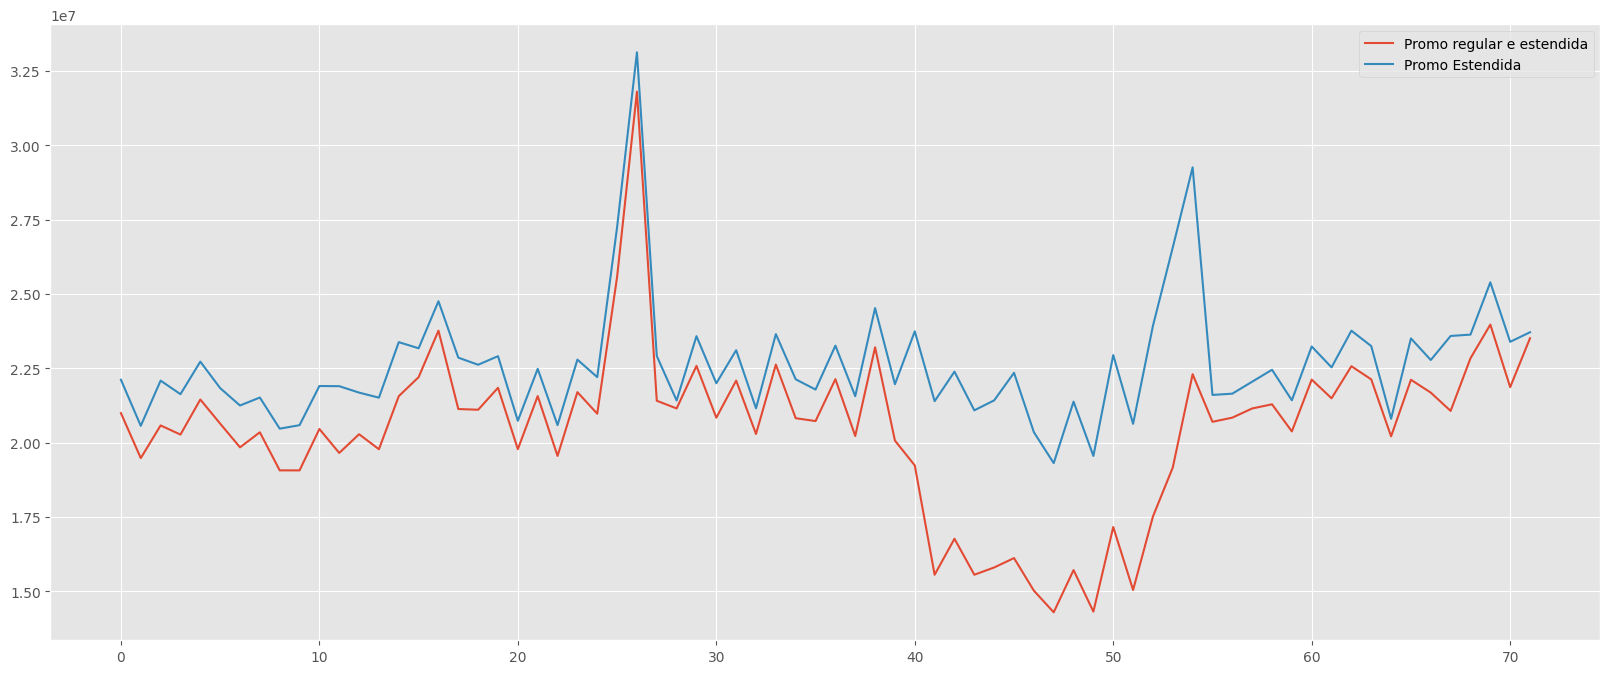

In [ ]:

df_aux1 = df4[( df4['promo'] == 1) & ( df4['promo2'] == 1)][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = df_aux1.plot(figsize=(20,8))

df_aux2 = df4[( df4['promo'] == 1) & ( df4['promo2'] == 0)][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
df_aux2.plot( figsize=(20,8), ax=ax )

ax.legend( labels=['Promo regular e estendida', 'Promo Estendida'])



### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**Hipótese Falsa.** O total de vendas das lojas abertas durante o Natal é menor.

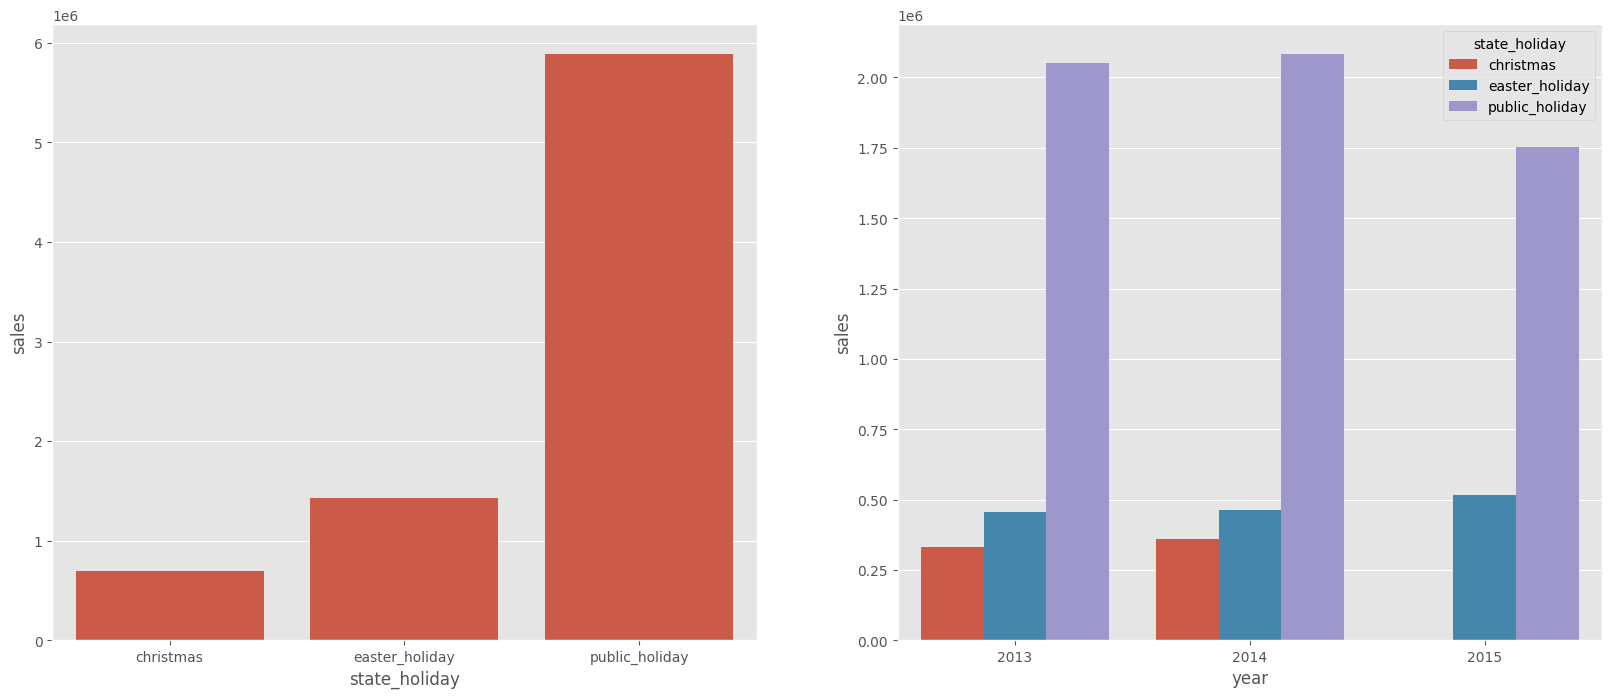

In [ ]:
df_aux = df4[df4['state_holiday'] != 'regular_day']
plt.figure(figsize=(20,8))

plt.subplot( 1, 2, 1 )
df_aux1 = df_aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=df_aux1 );

plt.subplot( 1, 2, 2 )
df_aux2 = df_aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=df_aux2 );


### **H8.** Lojas deveriam vender mais ao longo dos anos.
**Hipótese Falsa.** Lojas vendem MENOS ao longo dos anos.

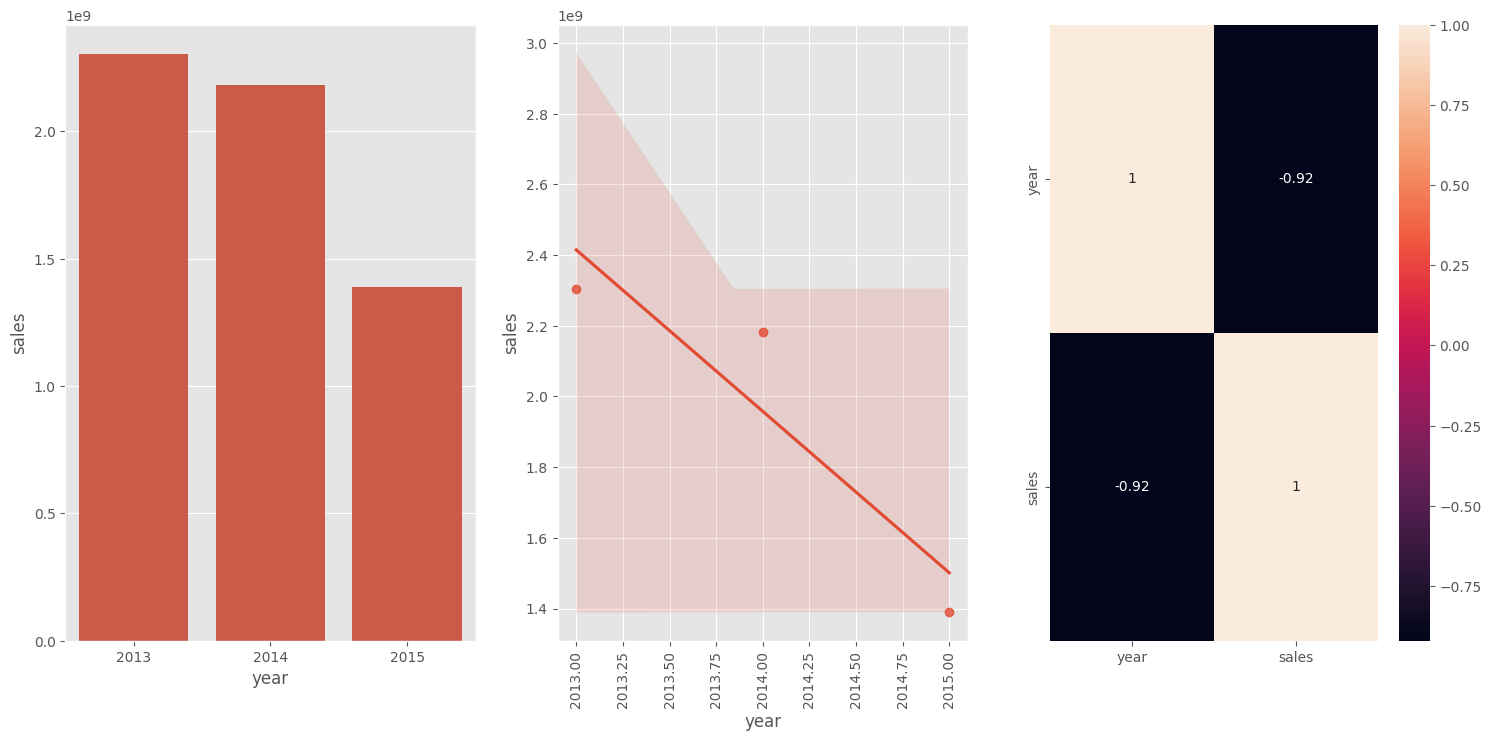

In [ ]:
df_aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()
plt.figure(figsize=(18,8))

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=df_aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=df_aux1 );
plt.xticks( rotation=90 )

plt.subplot( 1, 3, 3 )
sns.heatmap( df_aux1.corr( method='pearson' ), annot=True );

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**Hipótese Falsa.** Lojas vendem MENOS no segundo semestre do ano.

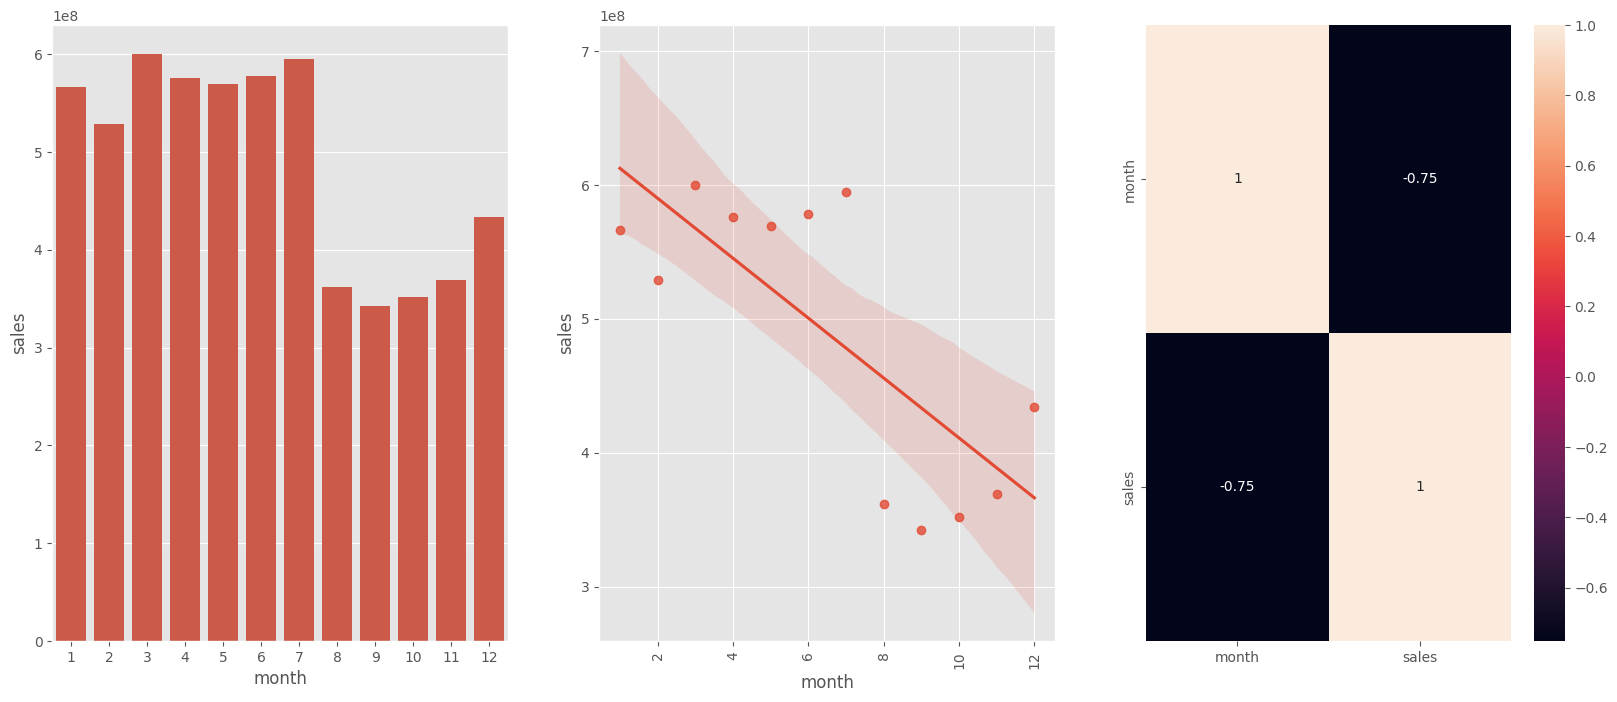

In [ ]:
df_aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()
plt.figure(figsize=(20,8))

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=df_aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=df_aux1 );
plt.xticks( rotation=90 )

plt.subplot( 1, 3, 3 )
sns.heatmap( df_aux1.corr( method='pearson' ), annot=True );

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**Hipótese Verdadeira**. Lojas vendem mais depois do dia 10 de cada mês.

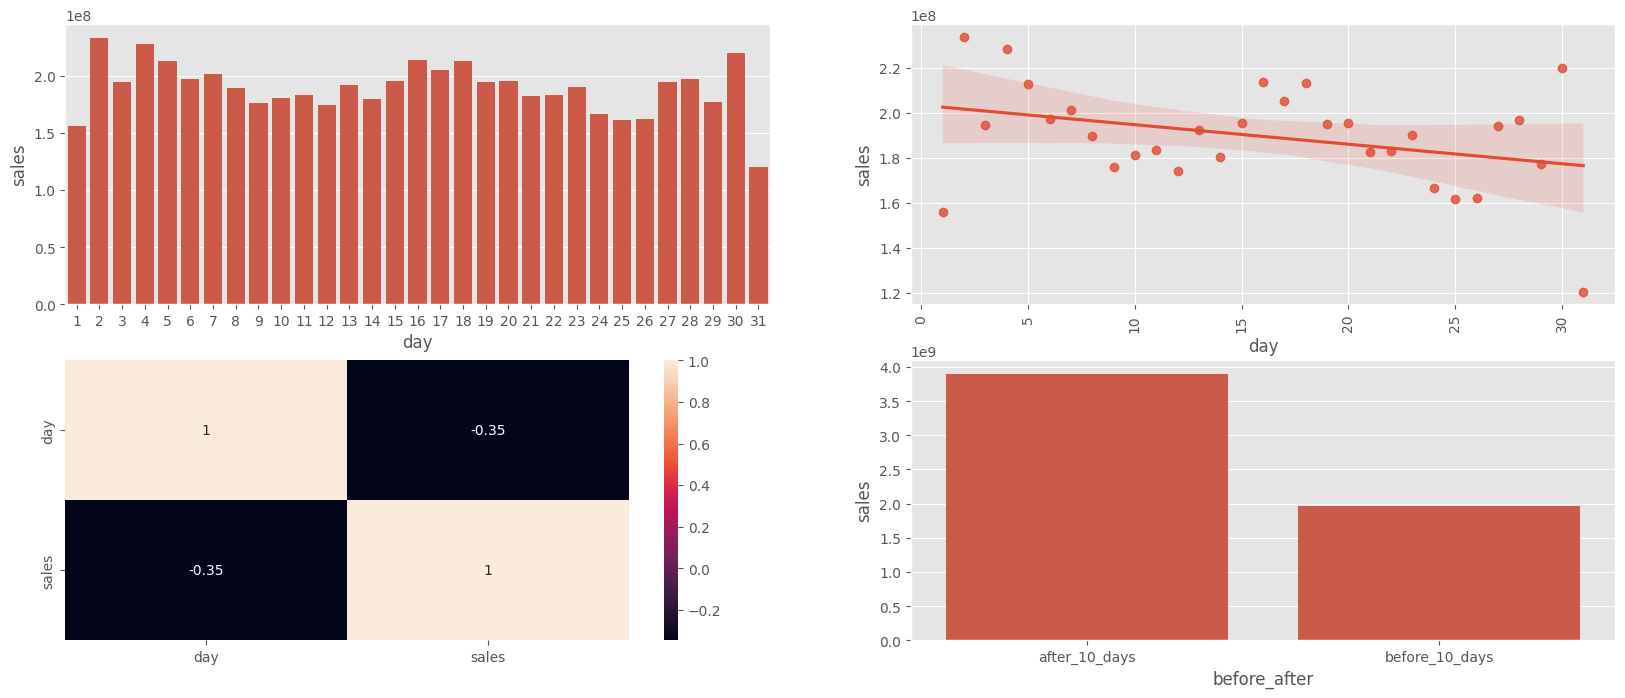

In [ ]:
df_aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()
plt.figure(figsize=(20,8))

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=df_aux1);

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=df_aux1);
plt.xticks( rotation=90 )

plt.subplot( 2, 2, 3 )
sns.heatmap( df_aux1.corr( method='pearson' ), annot=True );


df_aux1['before_after'] = df_aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
df_aux2 = df_aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=df_aux2);


### **H11**. Lojas deveriam vender menos aos finais de semana.
**Hipótese Verdadeira.** Lojas vendem MENOS aos finais de semana.

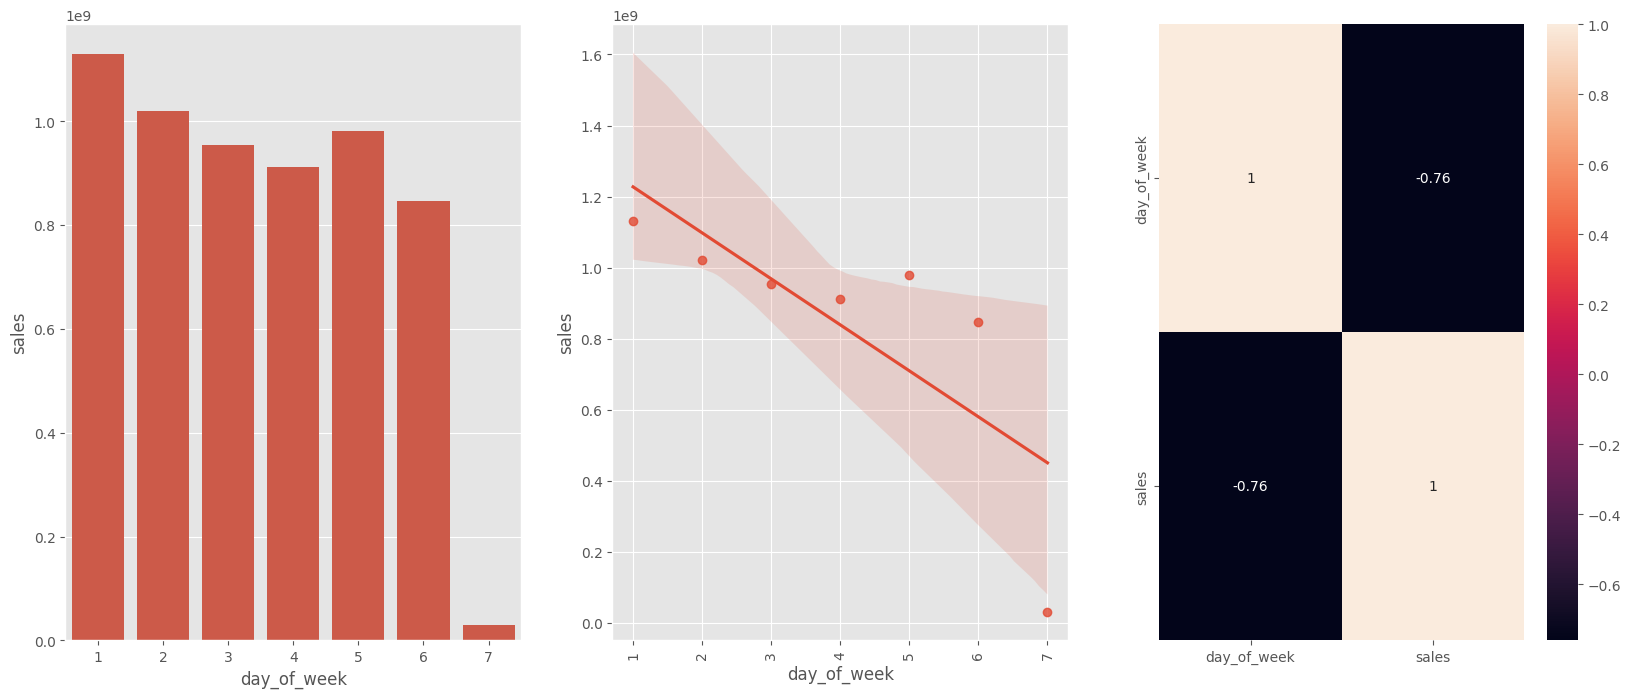

In [ ]:
df_aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()
plt.figure(figsize=(20,8))

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=df_aux1);

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=df_aux1 );
plt.xticks( rotation=90 )

plt.subplot( 1, 3, 3 )
sns.heatmap( df_aux1.corr( method='pearson' ), annot=True );

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**Hipótese Verdadeira.** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto.

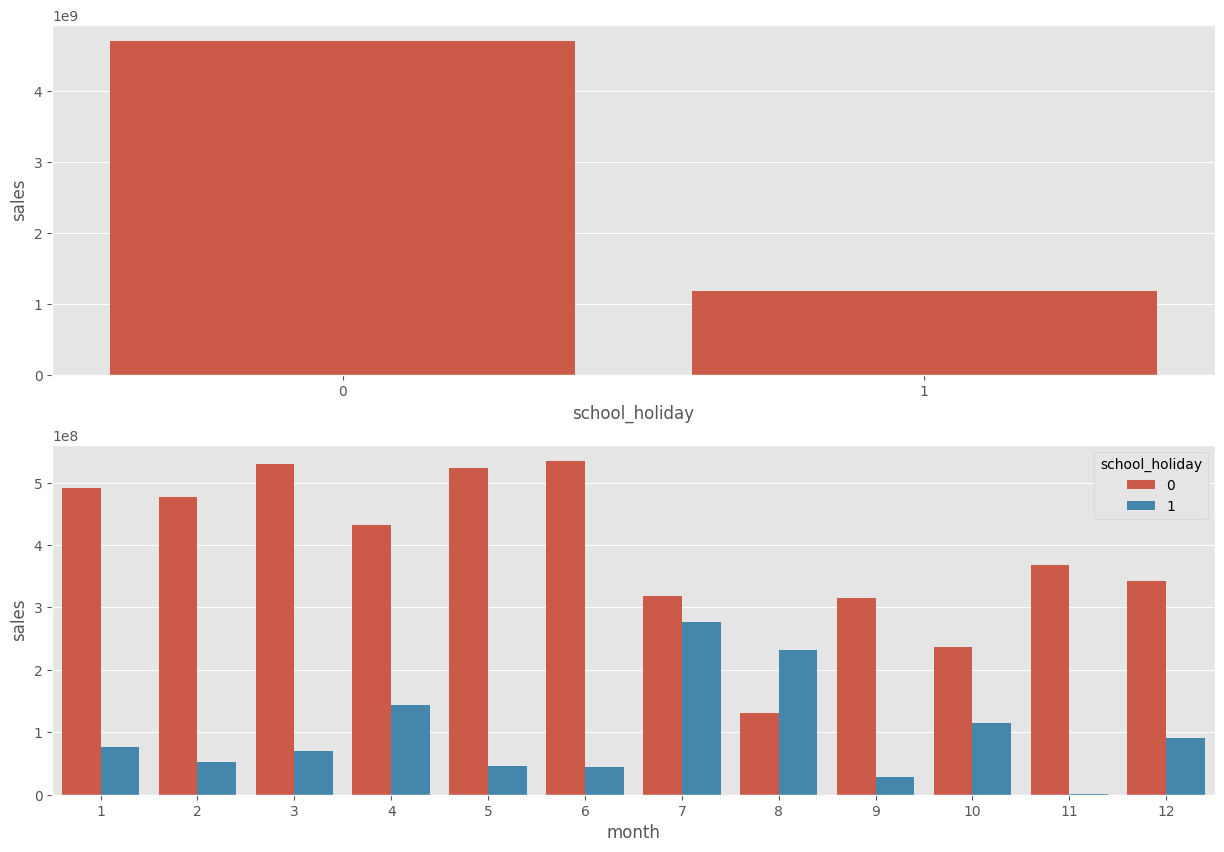

In [ ]:
plt.figure(figsize=(15,10))
df_aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=df_aux1 );

plt.subplot( 2, 1, 2 )
df_aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=df_aux2 );

## 4.2.1. Resumo das Hipóteses

In [ ]:
from tabulate import tabulate

In [ ]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Verdadeira', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H6', 'Falsa', 'Baixa'],
['H7', 'Falsa', 'Media'],
['H8', 'Falsa', 'Alta'],
['H9', 'Falsa', 'Alta'],
['H10', 'Verdadeira', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Verdadeira   Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Análise Multivariada

### 4.3.1. Numerical Attributes

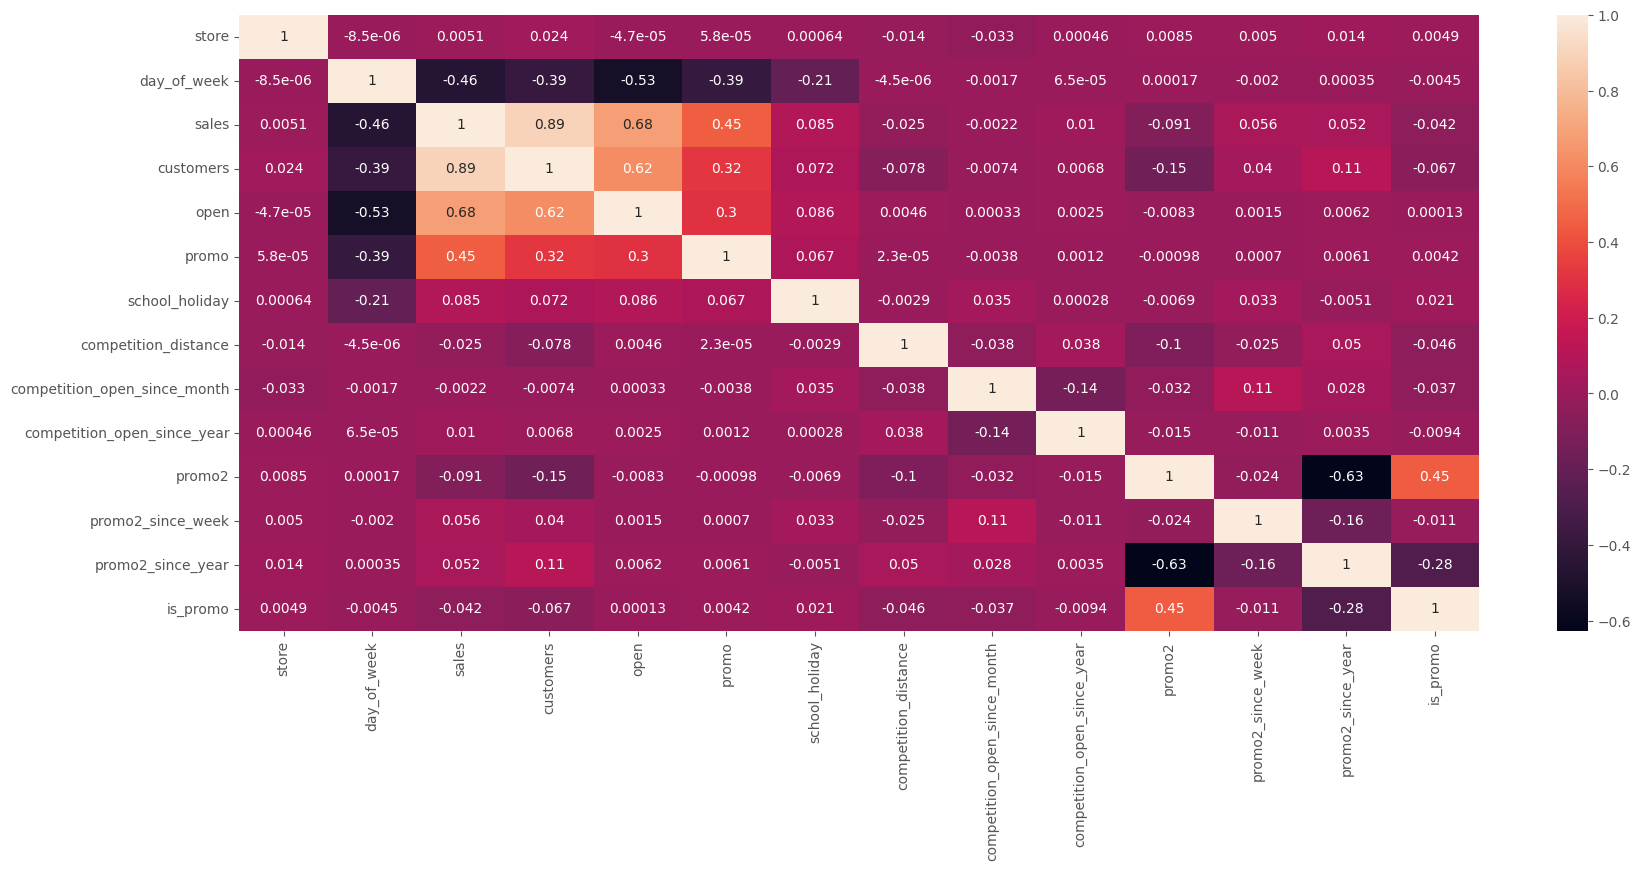

In [ ]:
plt.figure( figsize=(20,8) )
corr = num_attributes.corr( method='pearson' )
sns.heatmap( corr, annot=True );

### 4.3.2. Categorical Attributes

<Axes: >

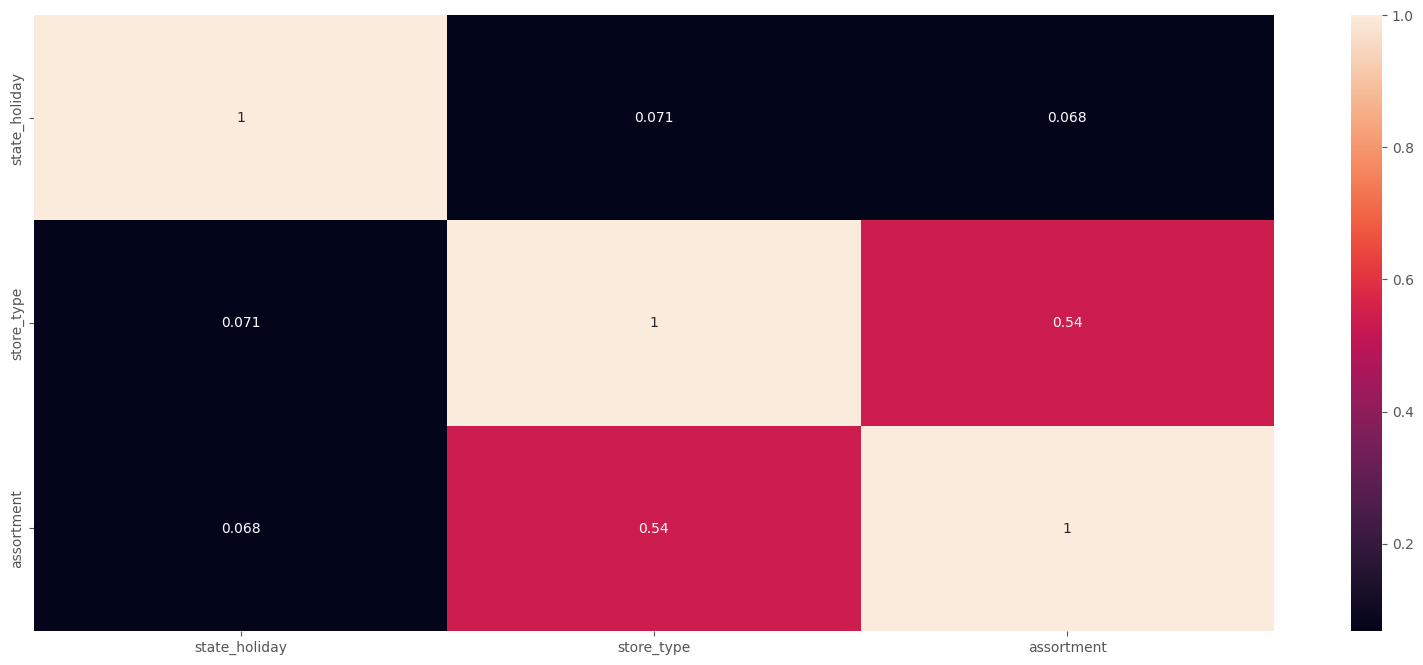

In [ ]:
# only categorical data
a = df4.select_dtypes( include='object' )
plt.figure(figsize=(20,8) )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
                'store_type': [a4, a5, a6],
                'assortment': [a7, a8, a9] })

d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# 5.0. DATA PREPARATION 

In [ ]:
df5 = df4.copy()

## ~~5.1 Normalization~~

**Não tem variávies com distribuição normal, plot no subtópico 4.1.2 - Numerical Variable**

## 5.2 Rescaling

In [ ]:
# a = df5.select_dtypes( include=['int64', 'float64'] )
# a.head()

### 5.3.1. Verificando outliers nas variáveis numéricas

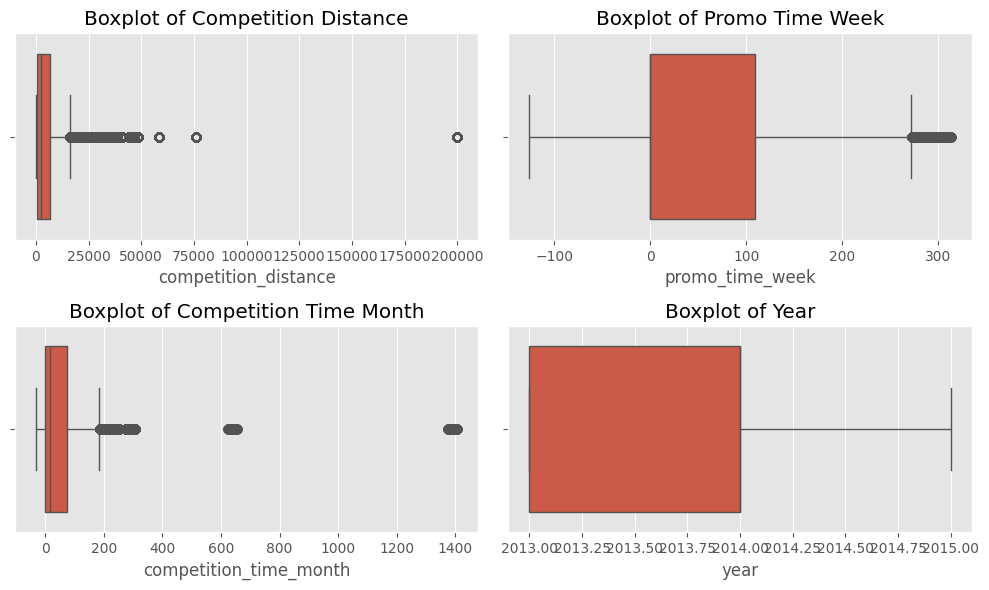

In [ ]:
plt.figure(figsize=(10, 6))

# competition_distance
plt.subplot(2, 2, 1)
sns.boxplot(x=df5['competition_distance'])
plt.title('Boxplot of Competition Distance')

# promo_time_week
plt.subplot(2, 2, 2)
sns.boxplot(x=df5['promo_time_week'])
plt.title('Boxplot of Promo Time Week')

# competition_time_month
plt.subplot(2, 2, 3)
sns.boxplot(x=df5['competition_time_month'])
plt.title('Boxplot of Competition Time Month')

# year
plt.subplot(2, 2, 4)
sns.boxplot(x=df5['year'])
plt.title('Boxplot of Year')

plt.tight_layout()

### 5.3.2 Rescaling

In [ ]:
# Rescaling
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( mms, open( 'parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb' ) )

## 5.4 Transformation

### 5.4.1. Encoding

In [ ]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'], dtype=int )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.4.2. Response Variable Transformation

In [ ]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.4.3. Nature Transformation

In [ ]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0. FEATURE SELECTION

In [ ]:
df6 = df5.copy()

## 6.1. Split dataset into Training and Test

In [ ]:
# Excluindo variáveis que deram origem à outras
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [ ]:
# Verificando as últimas 6 semanas
df6[['store', 'date']].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

In [ ]:
# Selecionando as 6 últimas semanas do dataset como test.

# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [ ]:
# cols_selected = boruta.support_.tolist()

# best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

### 6.2.1 Best Features from Boruta

In [ ]:
# cols_selected = boruta.support_.tolist()

# best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [ ]:

# Obtendo as colunas selecionadas pelo Boruta
# cols_selected_boruta = X_train.columns[boruta.support_].tolist()

In [ ]:
# Comparar com o resumo das hipóteses para ver se o meu feeling bate com o que o Boruta achou relevante
# cols_selected_boruta



## 6.3. Manual Feature Selection

In [ ]:
# adicionando month_sin e week_of_year_sin

cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. MACHINE LEARNING MODELLING

In [ ]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]
# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]


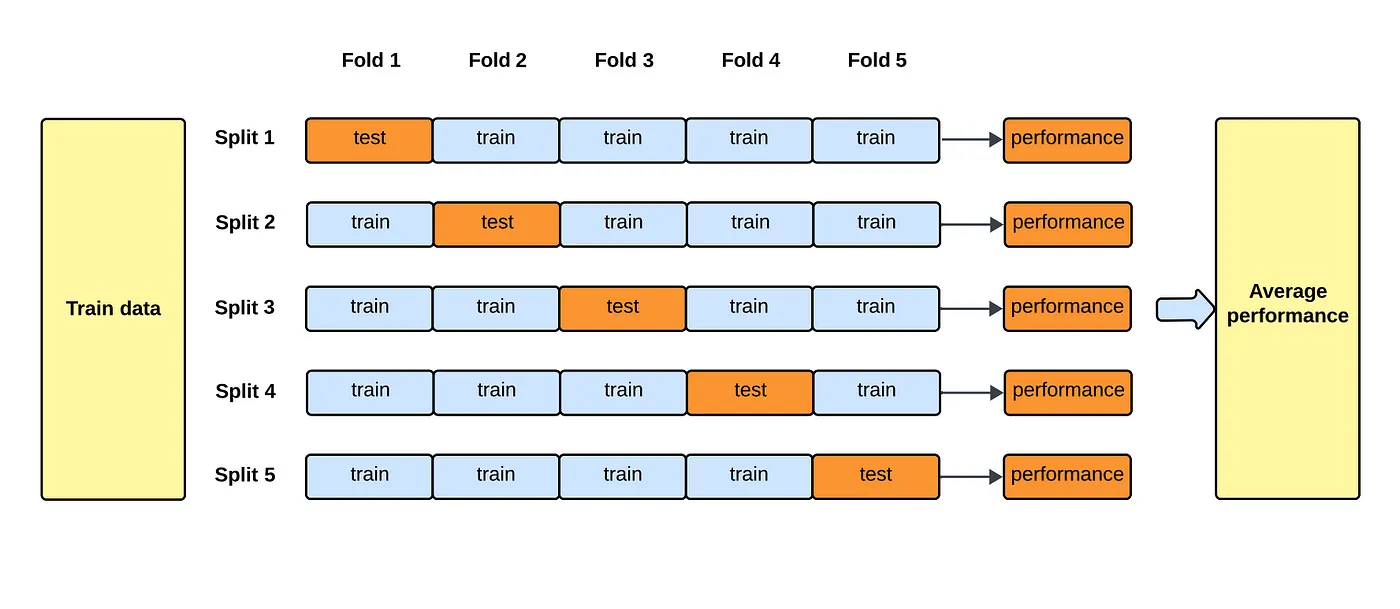

In [ ]:
# Cross Validation with Time Series Data
Image( 'img/cross_validation_image.png' )

## 7.1 Average Model


In [ ]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# Previsão
store_sales_avg = aux1[['store', 'sales']].groupby('store').mean().reset_index()
store_sales_avg.rename(columns={'sales': 'predictions'}, inplace=True)
aux1 = aux1.merge(store_sales_avg, how='left', on='store')
yhat_baseline = aux1['predictions']

# Desempenho
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline)) # Trazendo a coluna 'sales', que teve logaritmo aplicado, de volta à escala original
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 Linear Regression Model


In [ ]:
# model
lr = lm.LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression - Cross Validation

In [ ]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37


## 7.3 Linear Regression Regularized Model - Lasso


In [ ]:
# model
lrr = lm.Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Linear Regression Lasso - Cross Validation

In [ ]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26


## 7.4 Random Forest Regressor


In [ ]:
# model
rf = en.RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit(x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1(yhat_rf ) )
rf_result


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### 7.4.1. Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cv = cross_validation( x_training, 1, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,696.29+/-0.0,0.1+/-0.0,1003.2+/-0.0


## 7.5 XGBoost Regressor


In [ ]:
#model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1683.842595,0.249763,2464.956597


### 7.5.1 XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1858.17+/-290.66,0.25+/-0.01,2686.29+/-432.14


## 7.6. Comparing Model's Performance

### 7.6.1. Single Performance

In [ ]:
modelling_results = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_results.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,Average Model,1354.800353,0.206400,1835.135542
0,XGBoost Regressor,1683.842595,0.249763,2464.956597
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2. Real Performance - Cross Validation

In [ ]:
modelling_results_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_results_cv.sort_values( 'RMSE CV' )


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,696.29+/-0.0,0.1+/-0.0,1003.2+/-0.0
0,XGBoost Regressor,1858.17+/-290.66,0.25+/-0.01,2686.29+/-432.14
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26


# 8.0. Hyperparameter Fine Tunning

## 8.1. Random Search

In [ ]:
# import random

In [ ]:
#param = { 
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }

#MAX_EVAL = 5

In [ ]:
# final_result = pd.DataFrame()

#for i in range( MAX_EVAL ):
    # Escolhendo os valores para os parâmetros aleatoriamente
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )

    #model
#    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                n_estimators=hp['n_estimators'],
#                                eta=hp['eta'],
#                                max_depth=hp['max_depth'],
#                                subsample=hp['subsample'],
#                               colsample_bytree=hp['colsample_bytree'],
#                                min_child_weight=hp['min_child_weight'] )

    # performance
#   result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False )
#    final_result = pd.concat( [final_result, result] )

#final_result

## 8.2. Final Model

In [ ]:
# Aplicando os melhores hyperparametros encontrados com a Random Search
param_tuned = { 
    'n_estimators': 1000, #reduzi o n_estimators para diminuir o tamanho do modelo
    'eta': 0.05,
    'max_depth': 7,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'min_child_weight': 5
        }

In [ ]:
#model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )


# performance
xgb_result_tuned = ml_error ( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned 

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,711.261772,0.104962,1040.146127


In [ ]:
# Descobrindo o range da variável resposta
# np.expm1(y_test).min()
# np.expm1(y_test).max()
np.expm1(y_test).max() - np.expm1(y_test).min()

np.float64(40981.99999999998)

In [ ]:
# Obtendo MPE
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe
# Como o valor deu negativo, o erro do modelo tende a ser maior que o valor real ( superestimando )

np.float64(-0.008544241470001641)

# 9.0. TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [ ]:
df9 = X_test[cols_selected_boruta_full].copy()

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [ ]:
# sum of predictions
df9_aux = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store').apply( lambda x: mt.mean_absolute_error( x['sales'], x['predictions'] ), include_groups=False ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store').apply( lambda x: mt.mean_absolute_percentage_error( x['sales'], x['predictions'] ), include_groups=False ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df9_aux4 = pd.merge( df9_aux, df9_aux3, how='inner', on='store')

# Cenários
df9_aux4['worst_scenario'] = df9_aux4['predictions'] - df9_aux4['MAE']
df9_aux4['best_scenario'] = df9_aux4['predictions'] + df9_aux4['MAE']

# order columns
df9_aux4 = df9_aux4[['store', 'predictions','worst_scenario', 'best_scenario', 'MAE', 'MAPE' ]]


In [ ]:
df9_aux4.sort_values( 'MAPE', ascending=False ).head()

# As lojas 292 e 909 principalmente estão com erro acima de 50%, trata-se de outliers. 
# Portanto não se deve levar em conta a previsão dessas lojas e em um segundo ciclo do CRISP
# posso investigar especificamente que está acontecendo com elas.

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,105167.968750,101770.501144,108565.436356,3397.467606,0.586687
908,909,229248.734375,221560.417587,236937.051163,7688.316788,0.511321
594,595,341463.656250,336389.350058,346537.962442,5074.306192,0.347566
901,902,193318.468750,192091.158665,194545.778835,1227.310085,0.308038
875,876,193483.609375,189437.027705,197530.191045,4046.581670,0.305373


<Axes: xlabel='store', ylabel='MAPE'>

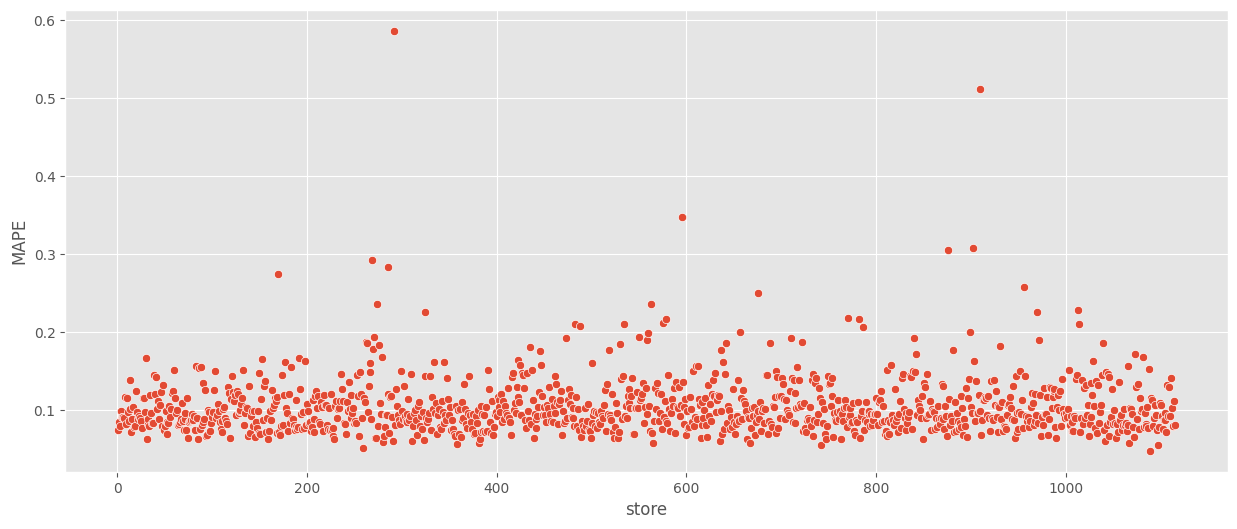

In [ ]:
# Graph View
plt.figure(figsize=(15, 6))
sns.scatterplot( x='store', y='MAPE', data=df9_aux4)

## 9.2. Total Performance

In [ ]:
df9_aux5 = df9_aux4[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df9_aux5['Values'] = df9_aux5['Values'].map( 'R${:,.2f}'.format )
df9_aux5

,Scenario,Values
0,predictions,"R$284,830,304.00"
1,worst_scenario,"R$284,033,963.60"
2,best_scenario,"R$285,626,620.68"


## 9.3. Machine Learning Performance

In [ ]:
# Criando colunas auxiliares para interpretar melhor o erro do modelo nos gráficos abaixo
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']


<Axes: xlabel='predictions', ylabel='error'>

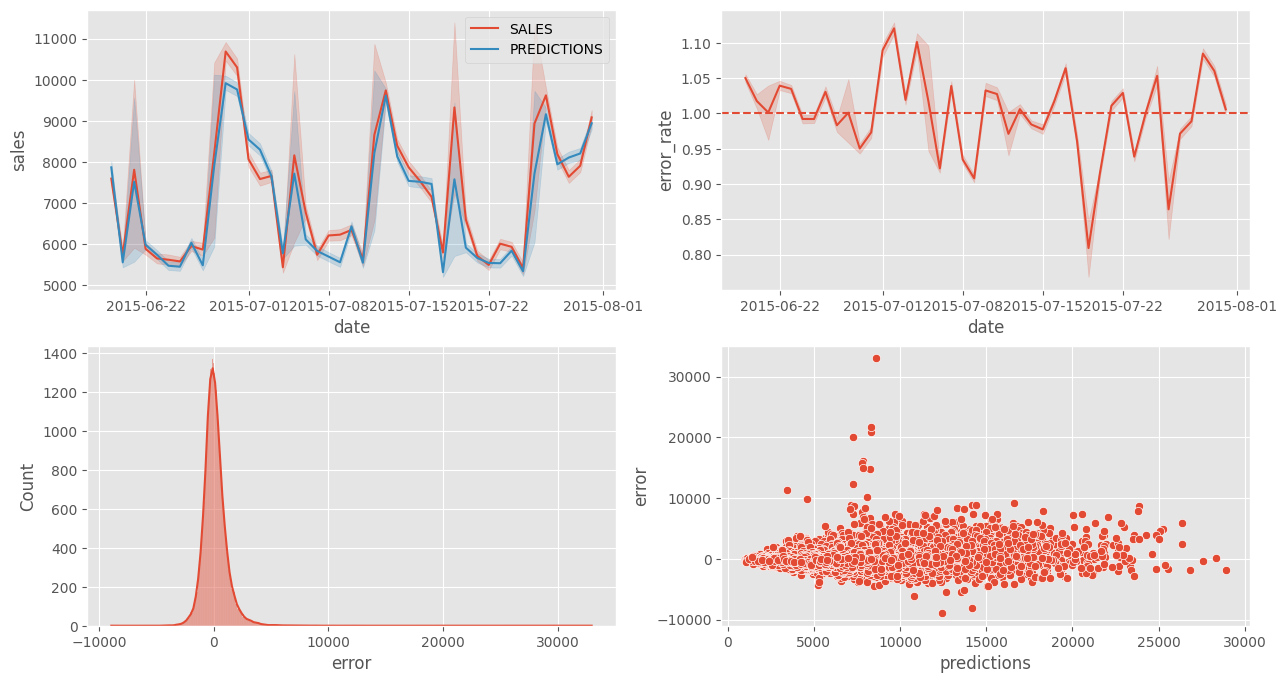

In [ ]:
plt.figure(figsize=(15, 8))
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.histplot(df9['error'], kde=True)

plt.subplot( 2, 2, 4 )
sns.scatterplot( x='predictions', y='error', data=df9)

# 10.0. DEPLOY MODEL TO PRODUCTION

In [ ]:
# Save trained model
pickle.dump( model_xgb_tuned, open('C:\\Users\\Samir\\Documents\\repos\\DataScience-Em-Producao\\model\\model_rossmann.pkl', 'wb'))


## 10.1. Rossmann Class

In [ ]:
import pickle
import inflection
import pandas   as pd
import numpy    as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='C:\\Users\\Samir\\Documents\\repos\\DataScience-Em-Producao\\'
        self.competition_distance_scaler    = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler  = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler         = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                    = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler              = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )

    def data_cleaning( self, df1 ):
    
        ## 1.1. Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
        'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
        'CompetitionDistance', 'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
            
        #competition_open_since_year  
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )
                                    
        #promo2_since_week 
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year   
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )            

        #promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',')  else 0, axis=1  )

        ## 1.6. Change Data Types
        # competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( np.int64 )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( np.int64 )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( np.int64 )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( np.int64 ) 

        return df1

    def feature_engineering( self, df2 ):
        # year
        df2['year'] = df2['date'].dt.year
        # month
        df2['month'] = df2['date'].dt.month
        # day
        df2['day'] = df2['date'].dt.day
        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week
        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )   

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das linnhas
        df2 = df2[df2['open'] != 0] 

        ## 3.2. Selecao de colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )

        return df2

    def data_preparation( self, df5 ):
        
        ## 5.2. Rescaling
        
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ## 5.3.1 Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )
        
        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding para X_train e X_test
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.3. Nature Transformation
        # day of week - Nature Transformation ( transforma o tempo em uma natureza cíclica )
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))

        # month ( transformação cíclica )
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

        # day ( transformação cíclica )
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))
        

        # week of year ( transformação cíclica )
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))
 

        cols_selected = [ 'store', 'promo', 'store_type', 'assortment','competition_distance', 
                        'competition_open_since_month', 'competition_open_since_year', 'promo2', 
                        'promo2_since_week', 'promo2_since_year', 'competition_time_month', 
                        'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 
                        'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']

        return df5[cols_selected]

    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )

        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )

        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
#model = pickle.load( open( 'C:\\Users\\Samir\\Documents\\repos\\DataScience-Em-Producao\\api\\model\\model_rossman.pkl', 'rb') )
home_path =  os.path.dirname(os.path.abspath(__file__))
model_path = os.path.join(home_path, 'model')
model = pickle.load(open(os.path.join(model_path, 'model_rossmann.pkl'), 'rb'))

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()

    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index[0] )
        
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )

        # Instantiate Rossmann class
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )

        # feature engineering
        df2 = pipeline.feature_engineering( df1 )

        # data preparation
        df3 = pipeline.data_preparation( df2 )

        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )

        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )


ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [ ]:
import requests
import json

In [ ]:
# loading test dataset
df10 = pd.read_csv( 'C:\\Users\\Samir\\Documents\\repos\\DataScience-Em-Producao\\data\\test.csv')


In [ ]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [22, 24, 10 ])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )


In [ ]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [ ]:
# API Call
# url = 'http://127.0.0.1:5000/rossmann/predict'
url = 'https://test-api-render-dtaf.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post( url, data=data, headers=header)
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [ ]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Numer {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'],
            d2.loc[i, 'prediction'] ) )

Store Numer 10 will sell R$194,359.93 in the next 6 weeks
Store Numer 22 will sell R$223,022.61 in the next 6 weeks
Store Numer 24 will sell R$341,169.47 in the next 6 weeks
